In [1]:
import numpy as np
import sys
import pandas as pd
from matplotlib import pyplot as plt
sys.path.append('/home/cayjobla/Desktop/Research/delay-optimizer')
from DelayEffects.Analyzer import Analyzer

In [2]:
loss_name = 'Ackley'

## Defining Delay Types

In [3]:
def undelayed(analyzer):
    """Returns the mean of the final loss values after optimization.
    Optimization type : Undelayed
    """
    # Optimize
    analyzer.calculate_save_values(False, save_grad=False, save_state=False, 
                                   save_iters=False, break_opt=False)
    return np.mean(analyzer.final_losses)

def uniform(analyzer, num_delays=None):
    """Returns the mean of the final loss values after optimization.
    Optimization type : Persistent 
        (delayed by max_L in all dimensions)
    """
    # Define delays
    D = [max_L * np.ones(analyzer.n, dtype=int)]
    
    # Optimize
    analyzer.calculate_save_values(True, num_delays=num_delays, D=D, random=False, 
                                   save_grad=False, save_state=False, save_iters=False, 
                                   break_opt=False)
    return np.mean(analyzer.del_final_losses)

def stochastic(analyzer, num_delays=None):
    """Returns the mean of the final loss values after optimization.
    Optimization type : Stochastic 
        (delayed randomly in each dimension at each time step)
    """
    # Optimize
    analyzer.calculate_save_values(True, num_delays=num_delays, D=None, random=True, 
                                   save_grad=False, save_state=False, save_iters=False, 
                                   break_opt=False)
    return np.mean(analyzer.del_final_losses)

def decaying(analyzer, stochastic=False):
    """Returns the mean of the final loss values after optimization.
    Optimization type : Decaying 
        (max_L decays over time)
    """
    # Get array of decaying max_Ls
    m = analyzer.maxiter / (analyzer.max_L+1)
    L = np.repeat(np.arange(analyzer.max_L+1)[::-1], m)
    L = np.pad(L, (0,analyzer.maxiter-len(L)))
    
    # Define delays
    if stochastic is True:
        D = [np.random.randint(0,l+1,size=analyzer.n) for l in L]
    else:
        D = [l*np.ones(analyzer.n, dtype=int) for l in L]
    
    # Optimize
    analyzer.calculate_save_values(True, num_delays=analyzer.maxiter, D=D, random=False, 
                                   save_grad=False, save_state=False, save_iters=False, 
                                   break_opt=False)
    return np.mean(analyzer.del_final_losses)

def partial(analyzer, p, stochastic=False, num_delays=None):
    """Returns the mean of the final loss values after optimization.
    Optimization type : Partial 
        (p percent of the dimensions are delayed)
    """
    # Determine how many dimensions are delayed
    d = int(p * analyzer.n)
    if d == 0: d = 1
    
    # Choose which dimensions to delay at each time step
    dims = [np.random.choice(np.arange(0,analyzer.n), replace=False, size=d) 
            for i in range(analyzer.maxiter)]
    
    # Define delays
    D = [np.zeros(analyzer.n, dtype=int) for i in range(analyzer.maxiter)]
    if stochastic is True:
        for i in range(analyzer.maxiter):
            D[i][dims[i]] = np.random.randint(1, analyzer.max_L+1, size=d)
    else:
        for i in range(analyzer.maxiter):
            D[i][dims[i]] = analyzer.max_L
    
    # Optimize
    analyzer.calculate_save_values(True, num_delays=num_delays, D=D, random=False, 
                                   save_grad=False, save_state=False, save_iters=False, 
                                   break_opt=False)
    return np.mean(analyzer.del_final_losses)

In [4]:
def calc_means(analyzer, num_points, p, num_delays=None):
    # Initialize
    analyzer.initialize_points(num_points, 'random')
    
    # Get final loss means
    undelayed_mean = undelayed(analyzer)
    uniform_full_mean = uniform(analyzer, analyzer.maxiter)
    uniform_mean = uniform(analyzer, num_delays)
    stoch_full_mean = stochastic(analyzer, analyzer.maxiter)
    stoch_mean = stochastic(analyzer, num_delays)
    decay_mean = decaying(analyzer, False)
    decay_stoch_mean = decaying(analyzer, True)
    partial_mean = partial(analyzer, p, False, analyzer.maxiter)
    partial_stoch_mean = partial(analyzer, p, True, analyzer.maxiter)
    
    means = [undelayed_mean, uniform_full_mean, uniform_mean, stoch_full_mean, stoch_mean, 
             decay_mean, decay_stoch_mean, partial_mean, partial_stoch_mean]
    return means

def plot_means(means):
    first_bars = [means[1], means[3], means[5], means[7]]
    second_bars = [means[2], means[4], means[6], means[8]]
    width = 0.35
    ind = np.arange(5)
    
    plt.bar([width/2], [means[0]], width, color='C1')
    plt.bar(ind[1:], first_bars, width, color=['C0', 'C2', 'C3', 'C4'])
    plt.bar(ind[1:] + width, second_bars, width, color=['C0', 'C2', 'C3', 'C4'], 
            alpha=0.5)
    
    delay_names = ["Undelayed", "Uniform", "Stochastic", "Decaying", "Partial"]
    plt.xticks(ind+width/2, delay_names, rotation='vertical', fontsize=12)

In [5]:
# Initialize for max_L = 1
max_L = 1
ackley2d = Analyzer(2, loss_name, max_L=max_L, verbose=True)
ackley10d = Analyzer(10, loss_name, max_L=max_L, verbose=True)
ackley100d = Analyzer(100, loss_name, max_L=max_L, verbose=True)
ackley1000d = Analyzer(1000, loss_name, max_L=max_L, verbose=True)

2d Ackley function initialized with parameters:
	Delayed: {'step_size': 740.0, 'min_learning_rate': 0.23, 'max_learning_rate': 2.98}
	Undelayed: {'step_size': 740.0, 'min_learning_rate': 0.23, 'max_learning_rate': 2.98}
10d Ackley function initialized with parameters:
	Delayed: {'step_size': 740.0, 'min_learning_rate': 0.23, 'max_learning_rate': 2.98}
	Undelayed: {'step_size': 740.0, 'min_learning_rate': 0.23, 'max_learning_rate': 2.98}
100d Ackley function initialized with parameters:
	Delayed: {'step_size': 740.0, 'min_learning_rate': 0.23, 'max_learning_rate': 2.98}
	Undelayed: {'step_size': 740.0, 'min_learning_rate': 0.23, 'max_learning_rate': 2.98}
1000d Ackley function initialized with parameters:
	Delayed: {'step_size': 740.0, 'min_learning_rate': 0.23, 'max_learning_rate': 2.98}
	Undelayed: {'step_size': 740.0, 'min_learning_rate': 0.23, 'max_learning_rate': 2.98}


In [6]:
means2d = calc_means(ackley2d, 50, 0.5, num_delays=1000)
means10d = calc_means(ackley10d, 50, 0.5, num_delays=1000)
means100d = calc_means(ackley100d, 50, 0.5, num_delays=1000)
means1000d = calc_means(ackley1000d, 50, 0.5, num_delays=1000)

IndexError: list index out of range

In [ ]:
# Initialize figure
fig = plt.figure(figsize=(20, 4))
ax = fig.subplots(1, 4)

ax = plt.subplot(141)
plot_means(means2d)
plt.ylabel("Average Final Loss")
plt.title("Ackley 2d", fontsize=14)

ax = plt.subplot(142)
plot_means(means10d)
plt.title("Ackley 10d", fontsize=14)

ax = plt.subplot(143)
plot_means(means100d)

ax = plt.subplot(144)
plot_means(means1000d)

fig.suptitle("Average Final Loss for Delayed and Undelayed Optimization", y=1.1, size=20)
plt.savefig("ack_types1.png", bbox_inches="tight")
plt.show()

In [ ]:
delay_name = ["Undelayed:", "Uniform full iters:", "Uniform delay:", "Stochastic full iters:", 
             "Stochastic delay:", "Decaying delay:", "Decaying Stochastic:", "Partial delay:",
             "Partial Stochastic:"]
means = {2:means2d, 10:means10d, 100:means100d, 1000:means1000d}

for n in [2, 10, 100, 1000]:
    print(f"Ackley {n}d")
    for i in range(9):
        print(delay_name[i], means[n][i])
    print('\n')

In [21]:
analyzer = ackley1000d
analyzer.initialize_points(50, 'random')
analyzer.calculate_save_values(False, num_delays=1000, D=None, random=True, 
                                save_grad=False, save_state=False, save_iters=False, 
                                break_opt=False)

In [22]:
analyzer.calculate_save_values(True, num_delays=analyzer.maxiter, D=None, random=True, 
                                save_grad=False, save_state=False, save_iters=False, 
                                break_opt=False)

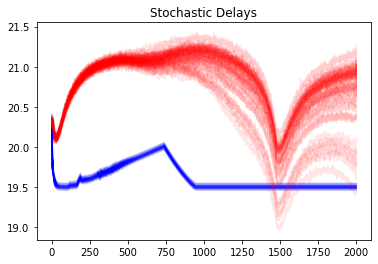

In [23]:
plt.plot(np.array(analyzer.loss_vals).T, c='b', alpha=0.1)
plt.title("Undelayed")

plt.plot(np.array(analyzer.del_loss_vals).T, c='r', alpha=0.1)
plt.title("Stochastic Delays")
plt.show()